In [1]:
# @title Imports and downloads
import os
import sys
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
import math
import gensim

from PIL import Image
from google.colab import drive

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, sampler
from torch.nn.utils.rnn import pad_sequence
from itertools import chain

import gensim.downloader as api
#from transformers import AutoTokenizer, AutoModel


nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00


In [2]:
drive.mount('/content/gdrive', force_remount=True)
data_path = "/content/gdrive/MyDrive/Medical_Image_Captioning/selected_dataset/selected_dataset" # Joona: Data location in this directory

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Colab_Notebooks/Medical_Image_Captioning/selected_dataset/selected_dataset"

In [3]:
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


### **Task 2:** Visualize sample image/caption pairs from both radiology and non-radiology classes.

In [4]:
# Path to the downloaded dataset
dataset_path = '/content/gdrive/MyDrive/Colab_Notebooks/Medical_Image_Captioning/selected_dataset/selected_dataset/train'

# Function to load and visualize sample image/caption pairs
def visualize_samples(dataset_path, num_samples=5):
    radiology_folder = os.path.join(dataset_path, 'radiology/images')
    non_radiology_folder = os.path.join(dataset_path, 'non-radiology/images')

    radiology_images = os.listdir(radiology_folder)
    non_radiology_images = os.listdir(non_radiology_folder)

    # Randomly select samples from radiology and non-radiology classes
    radiology_samples = random.sample(radiology_images, num_samples)
    non_radiology_samples = random.sample(non_radiology_images, num_samples)

    # Visualize radiology samples
    print("Radiology Samples:")
    for image_file in radiology_samples:
        image_path = os.path.join(radiology_folder, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    # Visualize non-radiology samples
    print("Non-Radiology Samples:")
    for image_file in non_radiology_samples:
        image_path = os.path.join(non_radiology_folder, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Visualize 5 samples from each class
visualize_samples(dataset_path, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# @title Task 7 Clean captions
# Captions preprocessor class

class CaptionsPreprocessor:
  def __init__(self):
      self.stopwords = stopwords
      self.lemmatizer = WordNetLemmatizer()
      self.stemmer = PorterStemmer()

  def remove_stopwords(self, captions):
      return ' '.join([t for t in captions.split() if t not in self.stopwords])

  def remove_punctuations(self, captions):
        captions = re.sub(r'[^\w ]+', "", captions)
        captions = ' '.join(captions.split())
        return captions

  def remove_specials(self, captions):
      return captions.replace('^[A-Za-z]', " ")

  def lemmatize(self, captions):
      return " ".join([self.lemmatizer.lemmatize(word) for word in captions.split()])

  def stem(self, captions):
      return " ".join([self.stemmer.stem(word) for word in captions.split()])

  def remove_extra_spaces(self, captions):
      return captions.replace("\s+"," ")

  def tokenize(self, captions):
      return nltk.word_tokenize(captions)

  def remove_single_char(self, captions):
      return ' '.join([word for word in captions.split() if len(word) > 1])

  def remove_words_with_numbers(self, captions):
      words = captions.split()
      words_without_numbers = [word for word in words if not any(char.isdigit() for char in word)]
      return ' '.join(words_without_numbers)

  def preprocess(self, captions):
      captions = captions.lower()
      #captions = self.remove_specials(captions)
      captions = self.remove_punctuations(captions)
      captions = self.remove_extra_spaces(captions)
      captions = self.remove_stopwords(captions)
      #captions = self.lemmatize(captions)
      #captions = self.stem(captions)
      captions = self.remove_words_with_numbers(captions)
      captions = self.remove_single_char(captions)
      captions = self.tokenize(captions)

      #print(captions)

      return captions

In [6]:
# @title Task 8 Getting the data
# Captions handling

class ImageCaptionsDataframeHandler:
    # Set paths to datasets
    def __init__(self, path):
        self.train_image_path = os.path.join(path, 'train/radiology/images')
        self.train_captions = os.path.join(path, 'train/radiology/traindata.csv')
        self.val_image_path = os.path.join(path, 'validation/radiology/images')
        self.val_captions = os.path.join(path, 'validation/radiology/valdata.csv')
        self.test_image_path = os.path.join(path, 'test/radiology/images_all')
        self.test_captions = os.path.join(path, 'test/radiology/testdata.csv')

    # Creates an image-caption dataframe from a dataset
    def create_df(self, csv_path, images):
        csv_df = pd.read_csv(csv_path)
        image_captions_df = pd.DataFrame(columns=['image', 'caption'])

        for index, row in csv_df.iterrows():
            image_path = os.path.join(images, row['name'])

            if os.path.exists(image_path) and image_path.endswith('.jpg'):
                image_captions_df = image_captions_df.append({
                    "image": row['name'],
                    "caption": row['caption']
                }, ignore_index=True)

        return image_captions_df

    # Creates training image-caption dataframe
    def get_training_dataframe(self):
        return self.create_df(self.train_captions, self.train_image_path)

    # Creates validation image-caption dataframe
    def get_val_dataframe(self):
        return self.create_df(self.val_captions, self.val_image_path)

    # Creates testing image-caption dataframe
    def get_test_dataframe(self):
        return self.create_df(self.test_captions, self.test_image_path)

class VocabularyHandler:
    def __init__(self):
        self.idxtow = {0: "<START>", 1: "<STOP>", 2: "<UNK>"}
        self.wtoidx = {"<START>": 0, "<STOP>": 1, "<UNK>": 2}
        self.preprocessor = CaptionsPreprocessor()
        self.caption_lengths = []
        self.weights_matrix = np.random.normal(scale=0.6, size=(300,))

    def __len__(self):
        return len(self.idxtow)

    def build_vocab(self, captions_list, pretrained_model):
        vocab = set()
        idx = 3

        for caption in captions_list:
            self.caption_lengths.append(len(self.preprocessor.preprocess(caption)))
            vocab.update(set(self.preprocessor.preprocess(caption)))

        for word in vocab:
            self.wtoidx[word] = idx
            self.idxtow[idx] = word
            idx = idx + 1

        self.weights_matrix = np.zeros((len(self.idxtow), 300))

        for i, word in self.idxtow.items():
            try:
                self.weights_matrix[i] = pretrained_model[word]
            except KeyError:
                self.weights_matrix[i] = np.random.normal(scale=0.6, size=(300,))

    def caption_to_num(self, text):
        #print(' '.join(self.preprocessor.preprocess(text)))
        return [
            self.wtoidx[word] if word in self.wtoidx else self.wtoidx["<UNK>"]
            for word in self.preprocessor.preprocess(text)
        ]

In [7]:
# @title Dataset class

def open_image(image_dir, image_name):
    return Image.open(os.path.join(image_dir, image_name)).convert("RGB")

class MedicalImagingDataset(Dataset):
    def __init__(self, image_dir, input_dataframe, batch_size, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.df = input_dataframe
        self.batch_size = batch_size

        self.preprocessor = CaptionsPreprocessor()

        self.images = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = VocabularyHandler()
        self.vocab.build_vocab(self.captions.tolist(), glove_model)

        self.caption_lengths = self.vocab.caption_lengths

    def __len__(self):
       return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image = open_image(self.image_dir, self.images[idx])

        if self.transform is not None:
            image = self.transform(image)

        caption_as_nums = [self.vocab.wtoidx["<START>"]]
        caption_as_nums += self.vocab.caption_to_num(caption)
        caption_as_nums.append(self.vocab.wtoidx["<STOP>"])

        return image, torch.tensor(caption_as_nums).long(), caption

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

In [8]:
# @title Training dataloader

def data_loader(image_folder, input_df, transform, batch_size, shuffle=False):
    dataset = MedicalImagingDataset(image_dir=image_folder, input_dataframe=input_df, batch_size=batch_size, transform=transform)
    indices = dataset.get_train_indices()
    initial_sampler = sampler.SubsetRandomSampler(indices=indices)

    loader = DataLoader(
        dataset=dataset,
        num_workers=1,
        batch_sampler=sampler.BatchSampler(sampler=initial_sampler, batch_size=batch_size, drop_last=False),
        shuffle=shuffle
    )
    return loader, dataset

### Encoder

In [322]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size = 1024):
        super(EncoderCNN, self).__init__()

        # get the pretrained densenet model
        self.densenet = models.densenet121(pretrained=True)

        # replace the classifier with a fully connected embedding layer
        self.densenet.classifier = nn.Linear(in_features=1024, out_features=1024)

        # add another fully connected layer
        self.embed = nn.Linear(in_features=1024, out_features=embed_size)

        # dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # activation layers
        self.prelu = nn.PReLU()

    def forward(self, images):

        # get the embeddings from the densenet
        densenet_outputs = self.dropout(self.prelu(self.densenet(images)))

        # pass through the fully connected
        embeddings = self.embed(densenet_outputs)

        return embeddings


### Decoder (Work in Progress)

In [323]:

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, num_layers=1):
        super(DecoderRNN, self).__init__()
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        self.embed.load_state_dict({'weight': torch.tensor(weights_matrix)})
        #self.embed.weight.requires_grad = False
        # activations
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, features, captions):
        # batch size
        batch_size = features.size(0)
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(self.device)
        # embed the captions
        #captions_embed = self.dropout(self.embed(captions))
        captions_embed = self.embed(captions)

        # pass the caption word by word
        for t in range(captions.size(1)):
            # for the first time step the input is the feature vector
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            # for the 2nd+ time step, using teacher forcer
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            # output of the attention mechanism
            out = self.fc_out(hidden_state)
            # build the output tensor
            outputs[:, t, :] = out
        return outputs

    def sample(self, features, vocab, max_length=50):
        result_caption = []
        x = features

        with torch.no_grad():
            hidden_s = torch.zeros((1, self.hidden_size)).to(self.device)
            cell_s = torch.zeros((1, self.hidden_size)).to(self.device)

            for _ in range(max_length):
                hidden_s, cell_s = self.lstm_cell(x, (hidden_s, cell_s))
                out = self.fc_out(hidden_s)
                predicted = out.argmax(1)

                if vocab.idxtow[predicted.item()] == "<STOP>":
                    break

                result_caption.append(predicted.item())
                x = self.embed(predicted)

        return [vocab.idxtow[idx] for idx in result_caption]

    def generate_caption(self, features, vocab):
        with torch.no_grad():  # make sure to not track the gradient since we are in inference mode
            # Initialize the hidden and cell states
            batch_size = features.size(0)
            hidden_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
            cell_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)

            # Placeholder for the generated caption
            generated_caption = []

            # Initial input is the image features
            inputs = features

            for _ in range(20):
                # Generate hidden state and cell state
                hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))

                # Output from the fully connected layer
                outputs = self.fc_out(hidden_state)

                # Softmax to generate probabilities
                outputs = self.softmax(outputs)

                # Get the word with the highest probability
                _, predicted_word = torch.max(outputs, dim=1)
                predicted_word = predicted_word.item()

                # Stop if end token is generated
                if vocab.idxtow[predicted_word] == "<STOP>":
                    break

                # Add the predicted word to the generated caption
                generated_caption.append(vocab.idxtow[predicted_word])

                # Use the predicted word as the next input
                inputs = self.embed(torch.tensor(predicted_word).to(self.device)).unsqueeze(0)

            return generated_caption

In [ ]:
# Create dataframes with image names and captions from the training dataset for now

dfc = ImageCaptionsDataframeHandler(path=data_path)

train_dataframe = dfc.get_training_dataframe()
val_dataframe = dfc.get_val_dataframe()
test_dataframe = dfc.get_test_dataframe()

In [364]:
# @title Parameters etc.

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# Saving location
model_path = "/content/gdrive/MyDrive/Medical_Image_Captioning/model/"

# Hyperparameters
embed_size = 300 # Size of the image embeddings
hidden_size = 1024  # Size of the hidden states in the LSTM decoder
batch_size = 8
num_layers = 1
learning_rate = 1e-4
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loader and dataset
train_loader, train_dataset = data_loader(dfc.train_image_path, train_dataframe, transform, batch_size)

# Validation loader and dataset
val_loader, val_dataset = data_loader(dfc.val_image_path, val_dataframe, transform, batch_size)

# Test loader and dataset
test_loader, test_dataset = data_loader(dfc.test_image_path, test_dataframe, transform, 1)

vocab_size = len(train_dataset.vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, train_loader.dataset.vocab.weights_matrix, num_layers).to(device)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
optimizer = optim.Adam(params=list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

#for name, param in encoder.densenet.named_parameters():
 #       if "fc.weight" in name or "fc.bias" in name:
  #          param.requires_grad = True
   #     else:
    #        param.requires_grad = False

total_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)

# get the losses for vizualization
losses = list()
val_losses = list()
save_every = 1

In [13]:
print(vocab_size)

6435


In [365]:
# @title Training loop

def training():

    # Training loop
    for epoch in range(1, num_epochs+1):

        for i_step in range(1, total_step+1):

            # zero the gradients
            decoder.zero_grad()
            encoder.zero_grad()

            # set decoder and encoder into train mode
            encoder.train()
            decoder.train()

            # Randomly sample a caption length, and sample indices with that length.
            indices = train_loader.dataset.get_train_indices()

            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            #val_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions, original = next(iter(train_loader))

            # make the captions for targets and teacher forcer
            captions_target = captions[:, 1:].to(device)
            captions_train = captions[:, :captions.shape[1]-1].to(device)

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions_train)

            # Calculate the batch loss
            loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

            # Backward pass
            loss.backward()

            # Update the parameters in the optimizer
            optimizer.step()

            # - - - Validate - - -
            # turn the evaluation mode on
            with torch.no_grad():

                # set the evaluation mode
                encoder.eval()
                decoder.eval()

                # get the validation images and captions
                val_images, val_captions, val_original = next(iter(val_loader))

                # define the captions
                captions_target = val_captions[:, 1:].to(device)
                captions_train = val_captions[:, :val_captions.shape[1]-1].to(device)

                # Move batch of images and captions to GPU if CUDA is available.
                val_images = val_images.to(device)

                # Pass the inputs through the CNN-RNN model.
                features = encoder(val_images)
                outputs = decoder(features, captions_train)

                # Calculate the batch loss.
                val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

            # append the validation loss and training loss
            val_losses.append(val_loss.item())
            losses.append(loss.item())

            # save the losses
            np.save('losses', np.array(losses))
            np.save('val_losses', np.array(val_losses))

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item())

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

        # Save the weights.
        if epoch % save_every == 0:
            print("\nSaving the model")
            torch.save(decoder.state_dict(), os.path.join(model_path, 'glove_decoder_final-%d.pth' % epoch))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'glove_encoder_final-%d.pth' % epoch))

In [366]:
training()

Epoch [1/10], Step [313/313], Loss: 6.1989, Val Loss: 8.8803
Saving the model
Epoch [2/10], Step [313/313], Loss: 6.3833, Val Loss: 9.0411
Saving the model
Epoch [3/10], Step [313/313], Loss: 6.2515, Val Loss: 9.2100
Saving the model
Epoch [4/10], Step [313/313], Loss: 6.2425, Val Loss: 9.0941
Saving the model
Epoch [5/10], Step [313/313], Loss: 5.3352, Val Loss: 9.1670
Saving the model
Epoch [6/10], Step [313/313], Loss: 4.6348, Val Loss: 9.2207
Saving the model
Epoch [7/10], Step [313/313], Loss: 5.2275, Val Loss: 9.2532
Saving the model
Epoch [8/10], Step [313/313], Loss: 5.5595, Val Loss: 9.3866
Saving the model
Epoch [9/10], Step [313/313], Loss: 4.8312, Val Loss: 9.5771
Saving the model
Epoch [10/10], Step [313/313], Loss: 3.4806, Val Loss: 9.7130
Saving the model


In [591]:
# @title Testing the model

# TODO #2: Specify the saved models to load.
encoder_file = os.path.join(model_path, 'glove_encoder_final-10.pth')
decoder_file = os.path.join(model_path, 'glove_decoder_final-10.pth')

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 1024

# The size of the vocabulary.
vocab_size = len(train_loader.dataset.vocab)
print(vocab_size)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, train_loader.dataset.vocab.weights_matrix)
decoder.eval()

# Load the trained weights.
#encoder.load_state_dict(torch.load(encoder_file, map_location=torch.device('cpu')))
#decoder.load_state_dict(torch.load(decoder_file, map_location=torch.device('cpu')))

encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

6435


DecoderRNN(
  (lstm_cell): LSTMCell(300, 1024)
  (fc_out): Linear(in_features=1024, out_features=6435, bias=True)
  (embed): Embedding(6435, 300)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
print(len(train_loader.dataset.vocab.wtoidx))

6435


In [592]:
pp = CaptionsPreprocessor()

def bleu_score(original, generated):
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([original], generated.split(), weights = (0.5, 0.5))
    print("BLEU score: ", BLEUscore)

def meteor_score(original, generated):
    METEORscore = nltk.translate.meteor([original], generated.split())
    print("METEOR score: ", METEORscore)

def nist_score(original, generated):
    NISTscore = nltk.translate.nist_score.sentence_nist([original], generated.split())
    print("NIST score: ", NISTscore)

def get_predictions():
    # Randomly sample a caption length, and sample indices with that length.
    indices = test_dataset.get_train_indices()

    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = sampler.SubsetRandomSampler(indices=indices)
    test_loader.batch_sampler.sampler = new_sampler

    image, captions, original = next(iter(test_loader))
    plt.imshow(np.squeeze(image).T)
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image)
    output = ' '.join(decoder.generate_caption(features, train_loader.dataset.vocab))
    #output = decoder.sample(features, train_loader.dataset.vocab)

    original = pp.preprocess(original[0])
    print("Original: ", " ".join(original))
    print("Generated: ", output)

    bleu_score(original, output)
    meteor_score(original, output)
    nist_score(original, output)

    print(type(original))
    print(type(output.split()))

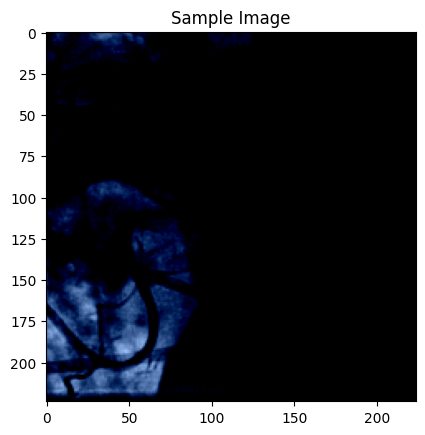

Original:  left internal mammary artery anastomosed left anterior descending artery
Generated:  coronary angiography showing large left anterior artery artery artery artery
BLEU score:  0.21081851067789192
METEOR score:  0.3468406593406593
NIST score:  1.079081111688036
<class 'list'>
<class 'list'>


In [618]:
get_predictions()